# **Actuarial Loss Prediction**

#Import & Install

In [92]:
!pip install distfit

In [93]:
import numpy as np
import pandas as pd
import gensim
import pickle 
import matplotlib.pyplot as plt
import scipy.stats as spst
from scipy.optimize import minimize
import scipy.special as spsp
from statsmodels.formula.api import ols, logit,poisson,negativebinomial
from statsmodels.base.model import GenericLikelihoodModel
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
from matplotlib.pyplot import figure
import plotly.express as px 
from plotly.offline import iplot
import warnings
from distfit import distfit
from gensim.utils import simple_preprocess
import nltk
import gensim.corpora as corpora
from pprint import pprint
import os
from nltk.corpus import stopwords 
from google.colab import files
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from mpmath import gamma
warnings.filterwarnings("ignore")

In [94]:
#upload = files.upload()

#Read Dataset (Access Code Input Needed)

In [95]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [96]:
link="https://drive.google.com/open?id=1ABO6HhzKnH7UDv_GYmZswzcdxD6AnVLU"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')  

#Data Cleaning & EDA

##Topic

In [97]:
df = pd.read_csv('train.csv')

In [98]:
df['UltimateIncurredClaimCost_log'] = np.log(df['UltimateIncurredClaimCost'])
df['InitialIncurredCalimsCost_log'] = np.log(df['InitialIncurredCalimsCost'])

In [99]:
# Storing a list of stopwords
nltk.download('stopwords') # start the NLTK Downloader and download the stopwords
from nltk.corpus import stopwords 
stop_words = stopwords.words('english') # Selecting english stopwords
stop_words.extend(['from', 'subject', 're', 'edu', 'use']) # adding new stopwords

# Defining a function to convert our descriptions to word tokens and remove ponctuation
def sent_to_words(descriptions):
    i = 0
    for description in descriptions:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(description), deacc=True)) 
        
# Defining a function to remove stopwords    
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
        
data = df.ClaimDescription.values.tolist()
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)

print(data_words[0])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['lifting', 'tyre', 'injury', 'right', 'arm', 'wrist', 'injury']


In [100]:
stop_words.extend(['left', 'right']) # adding new stopwords
  
data_wrl = df.ClaimDescription.values.tolist()
data_words_wrl = list(sent_to_words(data_wrl))
data_words_wrl = remove_stopwords(data_words_wrl)

# Create Dictionary
id2word = corpora.Dictionary(data_words_wrl)
# Create Corpus
texts = data_words_wrl

# Term Document Frequency
# Converts a collection of words to  a list of (word_id, word_frequency) 2-tuples.
corpus = [id2word.doc2bow(text) for text in texts]

# View first description
print(data_words_wrl[0])
print(corpus[0])

['lifting', 'tyre', 'injury', 'arm', 'wrist', 'injury']
[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1)]


In [101]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                           random_state=0)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.205*"eye" + 0.168*"foreign" + 0.168*"body" + 0.043*"metal" + '
  '0.041*"grinding" + 0.023*"struck" + 0.017*"grinder" + 0.017*"cornea" + '
  '0.017*"hit" + 0.017*"dust"'),
 (1,
  '0.150*"shoulder" + 0.092*"neck" + 0.069*"strain" + 0.042*"forearm" + '
  '0.037*"burn" + 0.036*"struck" + 0.026*"hot" + 0.021*"abrasion" + '
  '0.020*"arm" + 0.019*"muscle"'),
 (2,
  '0.128*"ankle" + 0.069*"sprained" + 0.056*"shoulder" + 0.055*"strain" + '
  '0.049*"slipped" + 0.039*"knee" + 0.027*"twisted" + 0.026*"air" + '
  '0.026*"sprain" + 0.026*"hose"'),
 (3,
  '0.213*"back" + 0.170*"strain" + 0.137*"lower" + 0.116*"lifting" + '
  '0.036*"strained" + 0.022*"pain" + 0.013*"upper" + 0.012*"injury" + '
  '0.012*"neck" + 0.010*"shoulder"'),
 (4,
  '0.133*"fell" + 0.078*"slipped" + 0.059*"back" + 0.045*"floor" + 0.037*"leg" '
  '+ 0.036*"strained" + 0.034*"knee" + 0.032*"bruised" + 0.027*"wet" + '
  '0.026*"truck"'),
 (5,
  '0.113*"foot" + 0.054*"bruised" + 0.049*"vehicle" + 0.048*"motor" + '
  '0.

In [102]:
arr = np.zeros((len(df),10))
sent_topics_df = pd.DataFrame(arr,columns = [0,1,2,3,4,5,6,7,8,9])

In [103]:
for i,row in enumerate(lda_model[corpus]):
    list_ = [0 for a in range(10)]
    for b in row:
        list_[b[0]] = b[1]
    sent_topics_df.loc[i] = list_

In [104]:
sent_topics_df.columns = ['0.Eye Injured', '1.Shoulder & Neck Strained', '2.Joint Sprained', '3.Back Strained(Lifting)',
                          '4.Back Strained(Fall)','5.Limb Bruised','6.Finger Lacerated','7.Fingers Lacerated','8.Soft Tissue Injury','9.Upper Limb Injury']

In [105]:
df = df.join(sent_topics_df)

In [106]:
df = df.rename(columns={"0.Eye Injured": "eye", "1.Shoulder & Neck Strained": "Shoulder_Neck_Strained", 
                   "2.Joint Sprained": "Joint_Sprained","3.Back Strained(Lifting)": "Back_Strained_Lifting",
                   "4.Back Strained(Fall)": "Back_Strained_Fall","5.Limb Bruised": "Limb_Bruised",
                   "6.Finger Lacerated": "Finger_Lacerated","7.Fingers Lacerated": "Fingers_Lacerated",
                   "8.Soft Tissue Injury": "Soft_Tissue_Injury","9.Upper Limb Injury": "Upper_Limb_Injury"})

In [107]:
df['strained'] = df['Shoulder_Neck_Strained']+df['Joint_Sprained']
df['back'] = df['Back_Strained_Lifting']+df['Back_Strained_Fall']
df['finger'] = df['Finger_Lacerated']+df['Fingers_Lacerated']
df['limb'] = df['Limb_Bruised']+df['Soft_Tissue_Injury']+df['Upper_Limb_Injury']

In [108]:
df = df.drop(['Shoulder_Neck_Strained','Joint_Sprained','Back_Strained_Lifting','Back_Strained_Fall',
              'Finger_Lacerated','Fingers_Lacerated','Limb_Bruised','Soft_Tissue_Injury','Upper_Limb_Injury'],axis=1)

In [109]:
df['main_topic'] = df[['strained','back','finger','limb','eye']].idxmax(axis=1)

Text(0, 0.5, 'Density')

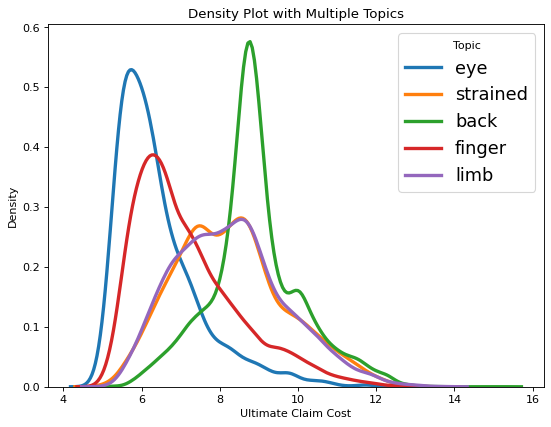

In [110]:
# List of five airlines to plot
figure(figsize=(8, 6), dpi=80)
topics = ['eye', 'strained', 'back','finger', 'limb']

# Iterate through the five airlines
for topic in topics:
    # Subset to the airline
    subset = df[df['main_topic'] == topic]
    
    # Draw the density plot
    sns.distplot(subset['UltimateIncurredClaimCost_log'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = topic)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Topic')
plt.title('Density Plot with Multiple Topics')
plt.xlabel('Ultimate Claim Cost')
plt.ylabel('Density')

##EDA

In [111]:
#read dataset
train=df.copy()                     
# delete records containing nan
train=train.dropna()
train['Diff']=(train['UltimateIncurredClaimCost']/train['InitialIncurredCalimsCost'])-1
#train

Target: UltimateIncurredClaimCost

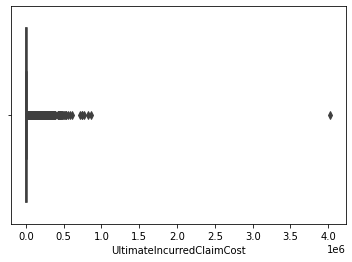

In [112]:
# we observe some ouliers 
sns.boxplot(train['UltimateIncurredClaimCost'])

# delete rows with outliers 
train=train.drop(train['UltimateIncurredClaimCost'].idxmax())

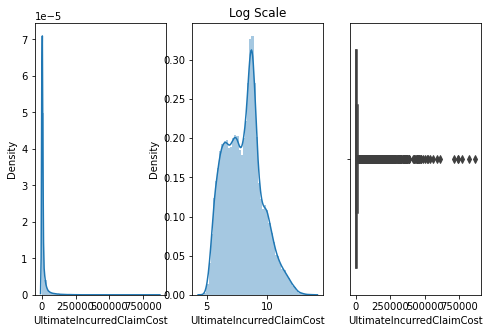

In [113]:
plt.figure(figsize = (8, 5))
plt.subplot(1, 3, 1)
sns.distplot(train['UltimateIncurredClaimCost'])
plt.subplot(1, 3, 2)
plt.title('Log Scale')
sns.distplot(np.log1p(train['UltimateIncurredClaimCost']));
plt.subplot(1, 3, 3)
sns.boxplot(train['UltimateIncurredClaimCost'])

# we see that the distribution of UltimateIncurredClaimCost is right-tailed
# we perform a log-transformation 
train['UltimateIncurredClaimCost_log']=np.log(train['UltimateIncurredClaimCost'])

Time

5


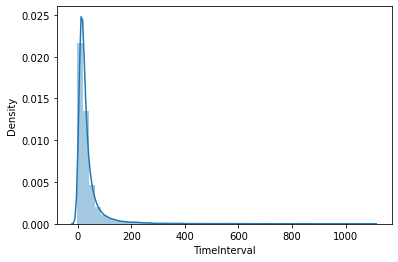

In [114]:
train=train.astype({"DateReported":"datetime64","DateTimeOfAccident":"datetime64"})
train['DayOfWeek'] = train['DateTimeOfAccident'].dt.dayofweek
train['Month'] = train['DateTimeOfAccident'].dt.month
train['Year'] = train['DateTimeOfAccident'].dt.year
train['TimeInterval']=(train['DateReported']-train['DateTimeOfAccident']).dt.days

sns.distplot(train['TimeInterval'])

# There are 5 claim of which the report date is before the accident date
# These accidents were reported on the same day but time of reporting weren't correctly recorded.
print(len(train[train['TimeInterval'] < 0]))


# Therefore, we set this to 0. 
train['TimeInterval'] = train['TimeInterval'].apply(lambda x: 0.0 if x < 0 else x)

Accident Numbers by Day Of Week/Months/Year

Text(0, 0.5, 'count')

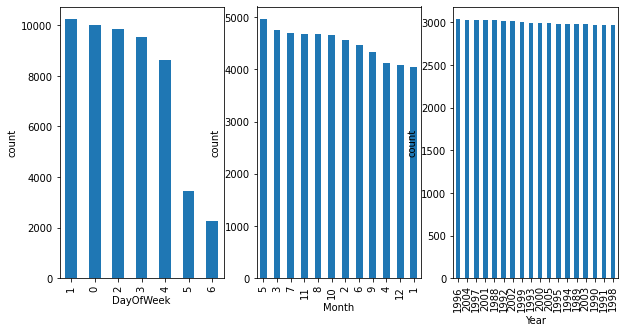

In [115]:
# We see that the claims happens more frequently through Monday to Thursday 
# The count variation in Month and Year is not noticeable
plt.figure(figsize = (10, 5))
plt.subplot(1, 3, 1)
train['DayOfWeek'].value_counts().plot(kind = 'bar')
plt.xlabel('DayOfWeek')
plt.ylabel('count')
plt.subplot(1, 3, 2)
train['Month'].value_counts().plot(kind = 'bar')
plt.xlabel('Month')
plt.ylabel('count')
plt.subplot(1, 3, 3)
train['Year'].value_counts().plot(kind = 'bar')
plt.xlabel('Year')
plt.ylabel('count')

HoursWorkedPerWeek

36
29


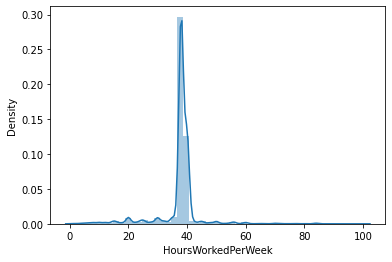

In [116]:
#train['HoursWorkedPerWeek'][train['HoursWorkedPerWeek']>168]=168
print(len(train['HoursWorkedPerWeek'][train['HoursWorkedPerWeek']>168]))
print(len(train[train['HoursWorkedPerWeek']==0]))
# There are 29 entries with HoursWorkedPerWeek 0.0 hours but they actually have jobs
# This could be due to wrong entry or these claimers could be in the nominal list of officers

# delete rows
train = train.drop(train[train['HoursWorkedPerWeek'] == 0].index)
train = train.drop(train[train['HoursWorkedPerWeek'] >= 168 ].index)

sns.distplot(train['HoursWorkedPerWeek'])

Gender

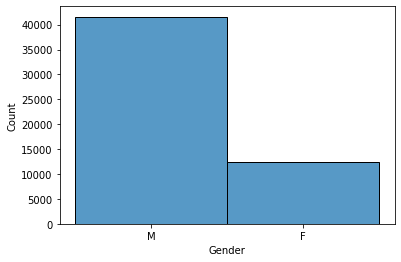

In [117]:
# we observe two Unknown Gender 
len(train[train['Gender']=='U'])
train = train.drop(train[train['Gender']=='U'].index)
# The male takes a large portion of the observation
sns.histplot(train['Gender']);

# 75% of the our records are male, indicating the imbalance in our dataset 

Dependent children

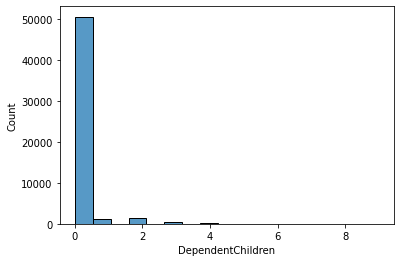

In [118]:
# The great majority of our records have no dependents, indicating no variation in this variable. 
# Therefore, we plan not to consider this in the future analysis.

len(train[train['DependentChildren']==0])/len(train)
sns.histplot(train['DependentChildren']);

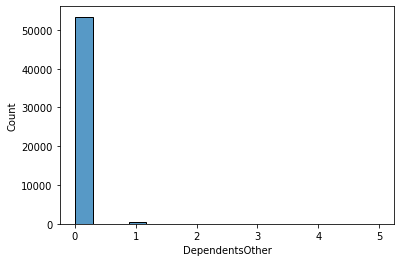

In [119]:
len(train[train['DependentsOther']==0])/len(train)
sns.histplot(train['DependentsOther']);

Marital Status

In [120]:
print(len(train[train['MaritalStatus']=='U']))
# we treat them as single 
train['MaritalStatus']=train['MaritalStatus'].replace('U','S')

5289


Age

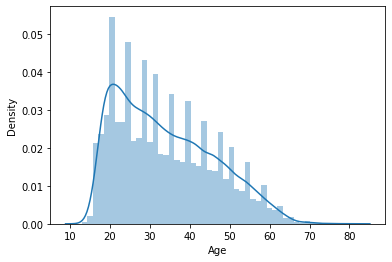

In [121]:
# We observe that claimers with younger age between 20-30 take up a large portion of our dataset
sns.distplot(train['Age']);

PartTimeFullTime

49024
0.9095024303365367


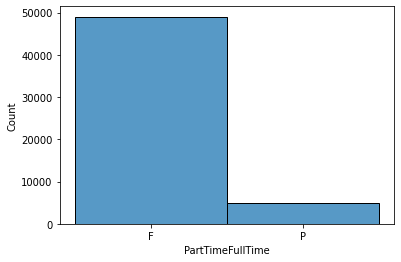

In [122]:
# We observe that claimers with fulltime job take up a large portion of our dataset
print(len(train[train['PartTimeFullTime']=='F']))
print(len(train[train['PartTimeFullTime']=='F'])/len(train))

sns.histplot(train['PartTimeFullTime']);

DaysWorkedPerWeek

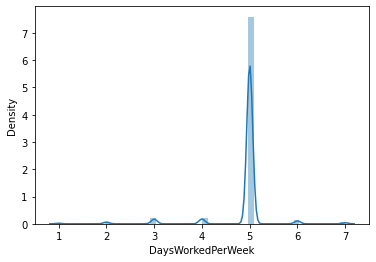

In [123]:
# most of the claimers in our dataset worked 5 days a week 
sns.distplot(train['DaysWorkedPerWeek'])

Weekly Wages

121


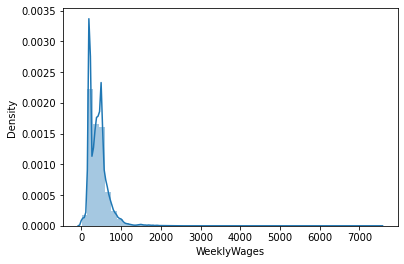

In [124]:
# There are 122 entries with WeeklyWages 1.0 
# These entries are most likely wrong entries and can be ignored
print(len(train[train['WeeklyWages'] == 1.0]))
train = train.drop(train[train['WeeklyWages'] ==1 ].index)

sns.distplot(train['WeeklyWages'])

InitialIncurredCalimsCost

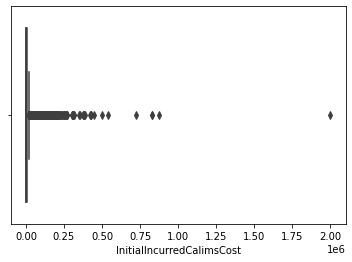

In [125]:
# we observe some ouliers 
sns.boxplot(train['InitialIncurredCalimsCost'])

In [126]:
# There are 46 entries with Inital Claim $1.0
print(len(train[train['InitialIncurredCalimsCost'] == 1]))

# There are one obvious outlier
print(len(train[train['InitialIncurredCalimsCost'] == 2.000000e+06]))

# delete rows with outliers 
train=train.drop(train['InitialIncurredCalimsCost'].idxmax())
train = train.drop(train[train['InitialIncurredCalimsCost'] == 1 ].index)

46
1


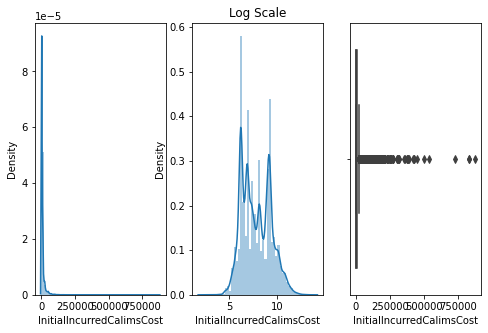

In [127]:
plt.figure(figsize = (8, 5))
plt.subplot(1, 3, 1)
sns.distplot(train['InitialIncurredCalimsCost'])
plt.subplot(1, 3, 2)
plt.title('Log Scale')
sns.distplot(np.log1p(train['InitialIncurredCalimsCost']));
plt.subplot(1, 3, 3)
sns.boxplot(train['InitialIncurredCalimsCost'])

# we see that the distribution of InitialIncurredCalimsCost is right-tailed
# we perform a log-transformation 
train['InitialIncurredCalimsCost_log']=np.log(train['InitialIncurredCalimsCost'])

Get_Dummy Variables

In [128]:
train['gender']=train['Gender']
train['maritalstatus']=train['MaritalStatus']   
train['parttimefulltime']=train['PartTimeFullTime']   

# rename columns 
train = pd.get_dummies(train, columns=['gender','maritalstatus','parttimefulltime'])
train=train.rename(columns={"gender_F": "Female", "gender_M": "Male", "maritalstatus_M": "Married","maritalstatus_S": "Single",'parttimefulltime_F':'FullTime','parttimefulltime_P':'PartTime'})

df=train[['Age','Female', 'Married','FullTime', 'WeeklyWages','HoursWorkedPerWeek', 
          'DaysWorkedPerWeek','DayOfWeek', 'Month', 'Year','TimeInterval',
          'ClaimDescription','InitialIncurredCalimsCost_log','UltimateIncurredClaimCost_log',
          'Diff','eye','strained','back','finger','limb','main_topic']]


Correlation

* InitialIncurredClaimCost & UltimateIncurredClaimCost has relatively larger POSITIVE correlation with Age, WeeklyWages and also InitialIncurredCalimsCost


* InitialIncurredClaimCost & UltimateIncurredClaimCost has NEGATIVE correlation with DaysWorkedPerWeek and whether a customer is working as Fulltime or not (these two have high correlation). 

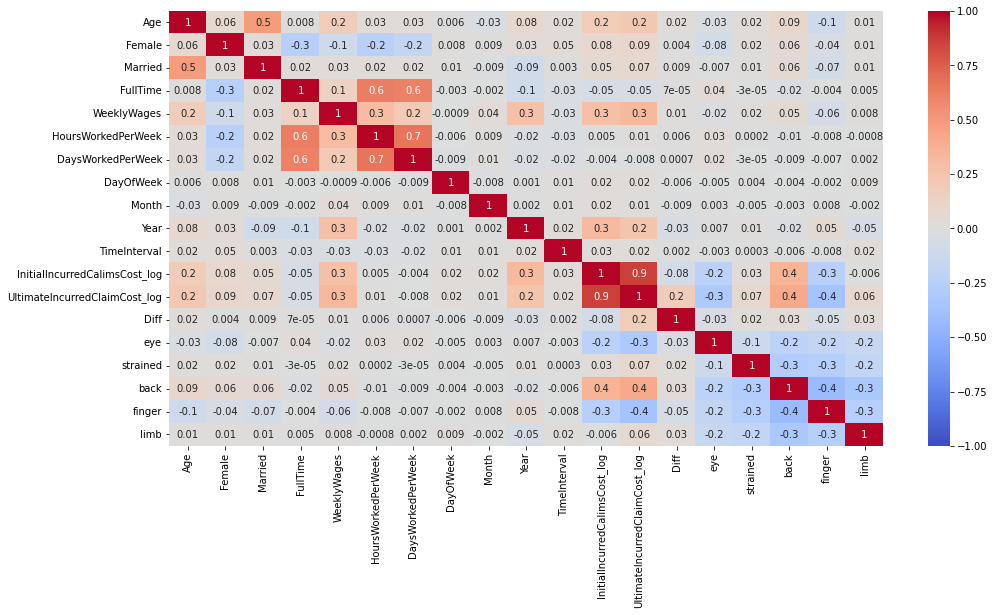

In [129]:
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',fmt='.1g')

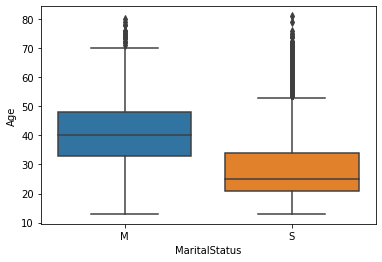

In [130]:
# We see that married people are generally older than those who are single (also indicated in correlation table)
sns.boxplot(x='MaritalStatus', y='Age',data=train)

<Figure size 576x360 with 0 Axes>

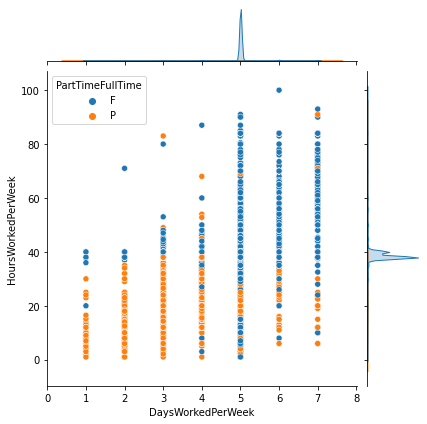

In [131]:
# From the correlation table, we see that DaysWorkedPerWeek and HoursWorkedPerWeek has high correlation.
# After further digging into these factors considering the whether the customer has a fulltime job or not, 
# the scattor plot shows that (1) the higher value of DaysWorkedPerWeek is associated with more HoursWorkedPerWeek and (2) people with a fulltime job work more frequently and longer than those parttime worker, which makes a lot of sense 
# The relationship between certain variables suggest that we only use some of them in our future prediction to avoid multicollinearity
#fig, axes = plt.subplots(1, 3, figsize=(18, 10))
plt.figure(figsize = (8, 5))
sns.jointplot(data = train, x = 'DaysWorkedPerWeek', y = 'HoursWorkedPerWeek', hue = 'PartTimeFullTime');

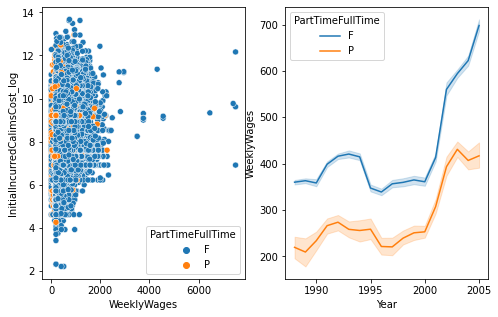

In [132]:
# People having a FullTime Job normally has higher weekly wages 
plt.figure(figsize = (8, 5))
plt.subplot(1,2,1)
sns.scatterplot('WeeklyWages','InitialIncurredCalimsCost_log', hue = 'PartTimeFullTime',data = train)

# We also see the WeeklyWages increases as the year goes by 
plt.subplot(1,2,2)
sns.lineplot(data = train, x = 'Year', y = 'WeeklyWages',hue='PartTimeFullTime');

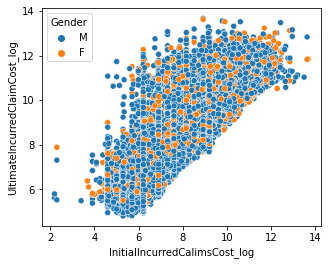

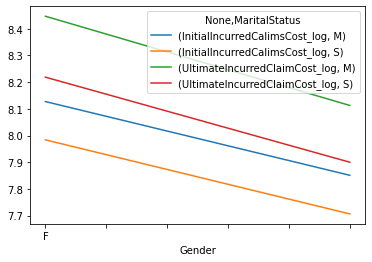

In [133]:
# InitialIncurredCalimsCost_log has very high correlation with UltimateIncurredClaimCost_log, indicating that we cannot exclude this factor in our future analysis.   
#fig, axes = plt.subplots(1, 2, figsize=(18, 10))
plt.figure(figsize = (5, 4))
sns.scatterplot('InitialIncurredCalimsCost_log', 'UltimateIncurredClaimCost_log',hue='Gender',data=train)

# also we can derive that Ultimate Claim cost is always more than the Inital Claim, which means that the insurance company are continuously encountering unexpected costs, which would decrease their profitability to a great extent. 
pd.pivot_table(data = train, index = 'Gender', 
               columns = ['MaritalStatus'], 
               values = ['InitialIncurredCalimsCost_log', 'UltimateIncurredClaimCost_log']).plot()
                                                                                         

ClaimDescription

In [134]:
# TOP10 most frequent instances of reported injuries
print(len(train['ClaimDescription'].unique()))

def top10(df):
    columns = df.select_dtypes(include=['object', 'category']).columns
    for col in columns:
        print("Top 10 unique values of " + col)
        print(df[col].value_counts().reset_index().rename(columns={"index": col, col: "Count"})[
              :min(10, len(df[col].value_counts()))])
df1=train[['ClaimDescription','InitialIncurredCalimsCost_log','UltimateIncurredClaimCost_log']]
top10(df1)

27962
Top 10 unique values of ClaimDescription
                                ClaimDescription  Count
0    SLIPPED ON ROLLER TENDONITIS RIGHT SHOULDER    289
1    SORTING ALUMINIUM BARS STRAIN SHOULDER NECK    278
2              SLIPPED USING LATHE IN EYE CORNEA    258
3  REDBACK SPIDER BITE RIGHT FOOT RIGHT FRACTURE    256
4                LIFTING TYRES LOWER BACK STRAIN    255
5          LIFTING BACK STRAIN LOWER BACK STRAIN    253
6                   FELL DOWN STAIRS BACK SPRAIN    236
7                     HIT AIR HOSE LACERATED LIP    233
8     JAMMED RIGHT HAND PUNCTURE WOUND RIGHT ARM    231
9         USING AIR HOSE STRAIN RIGHT KNEE RIGHT    229


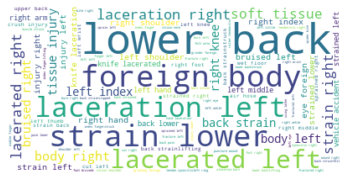

In [135]:
a = ''.join(df['ClaimDescription']).lower()
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(a)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53734 entries, 0 to 53999
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            53734 non-null  int64  
 1   Female                         53734 non-null  uint8  
 2   Married                        53734 non-null  uint8  
 3   FullTime                       53734 non-null  uint8  
 4   WeeklyWages                    53734 non-null  float64
 5   HoursWorkedPerWeek             53734 non-null  float64
 6   DaysWorkedPerWeek              53734 non-null  int64  
 7   DayOfWeek                      53734 non-null  int64  
 8   Month                          53734 non-null  int64  
 9   Year                           53734 non-null  int64  
 10  TimeInterval                   53734 non-null  float64
 11  ClaimDescription               53734 non-null  object 
 12  InitialIncurredCalimsCost_log  53734 non-null 

#K-Means Segmentation

In [137]:
SSmodel=StandardScaler()
SSmodel.fit(df.iloc[:,[0,1,2,4,6]]) #except dependent variable
Train_x=SSmodel.transform(df.iloc[:,[0,1,2,4,6]])

In [138]:
n_cluster=2
#demo=train.loc[:,['Age', 'WeeklyWages', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek', 'Female', 'Married', 'Unmarried', 'Single', 'FullTime']]
model=KMeans(n_clusters=n_cluster)
model.fit(Train_x)
clusters=model.predict(Train_x)
df=df.assign(clusters=clusters)

In [139]:
df.groupby('clusters').count()

,Age,Female,Married,FullTime,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,DayOfWeek,Month,Year,TimeInterval,ClaimDescription,InitialIncurredCalimsCost_log,UltimateIncurredClaimCost_log,Diff,eye,strained,back,finger,limb,main_topic
clusters,,,,,,,,,,,,,,,,,,,,,
0,29364,29364,29364,29364,29364,29364,29364,29364,29364,29364,29364,29364,29364,29364,29364,29364,29364,29364,29364,29364,29364
1,24370,24370,24370,24370,24370,24370,24370,24370,24370,24370,24370,24370,24370,24370,24370,24370,24370,24370,24370,24370,24370


In [140]:
df.groupby('clusters').mean()

,Age,Female,Married,FullTime,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,DayOfWeek,Month,Year,TimeInterval,InitialIncurredCalimsCost_log,UltimateIncurredClaimCost_log,Diff,eye,strained,back,finger,limb
clusters,,,,,,,,,,,,,,,,,,,
0,27.002588,0.213425,0.000306,0.904271,398.627865,37.329573,4.893918,2.279458,6.554046,1996.774077,37.744177,7.713274,7.908990,1.141061,0.082051,0.163435,0.276963,0.259000,0.218390
1,42.062249,0.246040,0.921133,0.916619,439.488054,37.730652,4.923923,2.317645,6.457448,1996.177965,38.931801,7.970233,8.249057,1.417124,0.077012,0.169702,0.319329,0.209451,0.224309


In [141]:
df[df['clusters']==0].groupby('main_topic').mean()

,Age,Female,Married,FullTime,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,DayOfWeek,Month,Year,TimeInterval,InitialIncurredCalimsCost_log,UltimateIncurredClaimCost_log,Diff,eye,strained,back,finger,limb,clusters
main_topic,,,,,,,,,,,,,,,,,,,,
back,28.156057,0.245950,0.000228,0.895391,415.927461,37.154581,4.877709,2.279147,6.546543,1996.710700,36.840862,8.485148,8.820471,1.431232,0.025099,0.072499,0.739496,0.064502,0.098165,0
eye,26.174167,0.101710,0.000000,0.937894,385.326908,37.996377,4.940594,2.262826,6.531503,1996.890639,40.172367,6.609187,6.371033,0.145500,0.752628,0.064081,0.047192,0.057722,0.078191,0
finger,25.600908,0.189670,0.000368,0.902221,373.828809,37.258140,4.889829,2.260827,6.589253,1997.114219,37.358116,7.114304,7.056573,0.359406,0.023780,0.060192,0.065035,0.746415,0.104551,0
limb,27.190015,0.224912,0.000334,0.910837,404.839569,37.500075,4.906662,2.303056,6.547671,1996.246786,39.049090,7.728493,8.133658,1.767994,0.031145,0.091422,0.105248,0.089728,0.682183,0
strained,27.482295,0.234183,0.000472,0.899669,408.741577,37.238317,4.892823,2.291313,6.522663,1996.935080,37.237724,7.826136,8.152099,1.680503,0.032256,0.704215,0.090898,0.068508,0.104054,0


In [142]:
df[df['clusters']==1].groupby('main_topic').mean()

,Age,Female,Married,FullTime,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,DayOfWeek,Month,Year,TimeInterval,InitialIncurredCalimsCost_log,UltimateIncurredClaimCost_log,Diff,eye,strained,back,finger,limb,clusters
main_topic,,,,,,,,,,,,,,,,,,,,
back,42.404169,0.279693,0.918724,0.904634,451.117633,37.584294,4.917094,2.295645,6.440149,1996.004774,38.860037,8.589659,8.976908,1.853547,0.025126,0.072517,0.741010,0.061452,0.099657,1
eye,41.016129,0.118280,0.942652,0.958781,412.153184,38.480806,4.969534,2.281362,6.492234,1996.234767,33.966547,6.695610,6.487801,0.078470,0.756042,0.064639,0.044170,0.056499,0.078425,1
finger,41.489855,0.218937,0.920773,0.919227,416.153826,37.740334,4.925217,2.325024,6.535652,1996.643671,37.357101,7.305943,7.313050,0.813211,0.024981,0.061699,0.069766,0.731203,0.112293,1
limb,42.157641,0.247061,0.921372,0.919638,442.976078,37.663355,4.920601,2.363076,6.461746,1995.862979,41.504722,7.963509,8.416608,1.706820,0.029942,0.090590,0.118100,0.085791,0.675276,1
strained,42.404647,0.262019,0.917201,0.917468,452.452535,37.810849,4.922009,2.311165,6.367521,1996.342682,39.927083,8.046806,8.428539,1.447820,0.029581,0.698528,0.098944,0.067536,0.105274,1


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53734 entries, 0 to 53999
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            53734 non-null  int64  
 1   Female                         53734 non-null  uint8  
 2   Married                        53734 non-null  uint8  
 3   FullTime                       53734 non-null  uint8  
 4   WeeklyWages                    53734 non-null  float64
 5   HoursWorkedPerWeek             53734 non-null  float64
 6   DaysWorkedPerWeek              53734 non-null  int64  
 7   DayOfWeek                      53734 non-null  int64  
 8   Month                          53734 non-null  int64  
 9   Year                           53734 non-null  int64  
 10  TimeInterval                   53734 non-null  float64
 11  ClaimDescription               53734 non-null  object 
 12  InitialIncurredCalimsCost_log  53734 non-null 

# Variable Selection - Regression

### Backward Step-wise Model Selection

In [144]:
df_train, df_test=train_test_split(df,test_size=0.2, random_state=50)

In [145]:
import copy
variables=['Age', 'WeeklyWages', 'HoursWorkedPerWeek',
       'DaysWorkedPerWeek', 'Female', 'Married', 'FullTime', 
       'DayOfWeek', 'Month', 'Year', 'TimeInterval','InitialIncurredCalimsCost_log']

def construct_m(variables):
    model= 'UltimateIncurredClaimCost_log~' +variables[0]
    for i in range(1,len(variables)):
        model=model+"+"+variables[i]  
    return model 


def outofsampleR2(Prediction, Actual):
    R2=1-np.sum((Prediction-Actual)**2)/np.sum((Actual-np.mean(Actual))**2)
    return R2

def run_model(model,train,test):
    prediction=ols(model,train).fit().predict(test)
    prediction=np.exp(prediction)
    return outofsampleR2(prediction,np.exp(test.UltimateIncurredClaimCost_log))

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53734 entries, 0 to 53999
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            53734 non-null  int64  
 1   Female                         53734 non-null  uint8  
 2   Married                        53734 non-null  uint8  
 3   FullTime                       53734 non-null  uint8  
 4   WeeklyWages                    53734 non-null  float64
 5   HoursWorkedPerWeek             53734 non-null  float64
 6   DaysWorkedPerWeek              53734 non-null  int64  
 7   DayOfWeek                      53734 non-null  int64  
 8   Month                          53734 non-null  int64  
 9   Year                           53734 non-null  int64  
 10  TimeInterval                   53734 non-null  float64
 11  ClaimDescription               53734 non-null  object 
 12  InitialIncurredCalimsCost_log  53734 non-null 

In [147]:
model=construct_m(variables)
R2_best=run_model(model,df_train,df_test)

while len(variables)>0: 
    R2=[]
    for var in variables:
        variables_c=copy.copy(variables)
        variables_c.remove(var) 
        model=construct_m(variables_c)
        R2_c=run_model(model,df_train,df_test)
        R2.append(R2_c)
        #print(model)
    if R2_best>np.max(R2):
        break
    else:
        index_remove=np.where(R2==np.max(R2))[0][0]
        variables.remove(variables[index_remove])
        R2_best=np.max(R2)

print(R2_best)
variables

0.28160408468917986


['HoursWorkedPerWeek',
 'DaysWorkedPerWeek',
 'TimeInterval',
 'InitialIncurredCalimsCost_log']

### Elastic-Net Regression

In [148]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

In [149]:
dftotal=df[['Age', 'WeeklyWages', 'HoursWorkedPerWeek',
       'DaysWorkedPerWeek', 'Female', 'Married',
       'FullTime',  'DayOfWeek', 'Month', 'Year', 
       'TimeInterval', 'InitialIncurredCalimsCost_log',
       'UltimateIncurredClaimCost_log']]
train, test=train_test_split(dftotal,test_size=0.2, random_state=50)

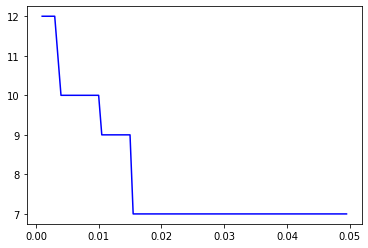

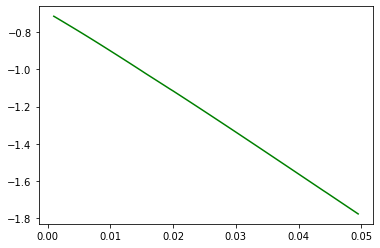

In [150]:
SSmodel=StandardScaler()
SSmodel.fit(train.iloc[:,:-1])
Train_x=SSmodel.transform(train.iloc[:,:-1])
Test_x=SSmodel.transform(test.iloc[:,:-1])
Alphas = np.arange(0.001,0.05,0.0005)
nz=[]
r2=[]
for a in Alphas:
    ENmodel=ElasticNet(alpha=a, l1_ratio=0.5, fit_intercept=False)
    ENmodel.fit(Train_x, train.UltimateIncurredClaimCost_log.values-np.mean(train.UltimateIncurredClaimCost_log.values))
    nonzeros = len(np.nonzero(ENmodel.coef_)[0])
    prediction = np.exp(ENmodel.predict(Test_x)+np.mean(train.UltimateIncurredClaimCost_log.values))
    ofsr2 = outofsampleR2(np.exp(test.UltimateIncurredClaimCost_log.values),prediction)
    nz = nz+[nonzeros]
    r2 = r2+[ofsr2]
plt.plot(Alphas,nz,'blue')
plt.show()
plt.plot(Alphas,r2,'green')

In [151]:
ENmodel=ElasticNet(alpha=0.05, l1_ratio=0.5, fit_intercept=False)
ENmodel.fit(Train_x, train.UltimateIncurredClaimCost_log.values-np.mean(train.UltimateIncurredClaimCost_log.values))
ENmodel.predict(Test_x)
for i in range(len(ENmodel.coef_)):
    print(train.columns[i],ENmodel.coef_[i]/np.std(train.iloc[:,i]))

Age 0.00471704554527518
WeeklyWages 0.0005114835471100029
HoursWorkedPerWeek -0.0
DaysWorkedPerWeek -0.0044643224564089945
Female 0.06380677299588772
Married 0.0
FullTime -0.014885016108418544
DayOfWeek -0.0
Month -0.0
Year -0.0040806121866558435
TimeInterval 0.0
InitialIncurredCalimsCost_log 0.8187420990458011


#Regression Analysis

## By Demographic 

In [152]:
import numpy as np
a = np.array(list(df))
b = [0,1,2,3,4,6,9,12,15,16,17,18,19]
#list(a[b])

In [153]:
model_text = 'UltimateIncurredClaimCost_log~'
for i in list(a[b]):
    model_text = model_text+'+'+i

In [154]:
#Group0
df_0 = df[df['clusters']==0]
Model=ols(model_text,df_0).fit()
Model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     UltimateIncurredClaimCost_log   R-squared:                       0.811
Model:                                       OLS   Adj. R-squared:                  0.811
Method:                            Least Squares   F-statistic:                     9675.
Date:                           Fri, 31 Dec 2021   Prob (F-statistic):               0.00
Time:                                   17:15:32   Log-Likelihood:                -29441.
No. Observations:                          29364   AIC:                         5.891e+04
Df Residuals:                              29350   BIC:                         5.903e+04
Df Model:                                     13                                         
Covariance Type:                       nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         6.2734      2.088      3.004      0.003       2.180      10.366
Age                               0.0060      0.000     12.637      0.000       0.005       0.007
Female                            0.0469      0.010      4.809      0.000       0.028       0.066
Married                           0.2592      0.220      1.178      0.239      -0.172       0.690
FullTime                         -0.0668      0.017     -3.854      0.000      -0.101      -0.033
WeeklyWages                       0.0007   1.97e-05     34.896      0.000       0.001       0.001
DaysWorkedPerWeek                -0.0467      0.009     -5.246      0.000      -0.064      -0.029
Year                             -0.0018      0.001     -2.121      0.034      -0.003      -0.000
InitialIncurredCalimsCost_log     0.7556      0.003    234.900      0.000       0.749       0.762
eye                              -1.7748      1.332     -1.333      0.183      -4.385       0.835
strained                         -0.6160      1.331     -0.463      0.644      -3.225       1.993
back                             -0.4087      1.332     -0.307      0.759      -3.019       2.201
finger                           -1.4132      1.331     -1.062      0.288      -4.022       1.196
limb                             -0.5350      1.332     -0.402      0.688      -3.145       2.075
==============================================================================
Omnibus:                    13450.927   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            97374.930
Skew:                           2.073   Prob(JB):                         0.00
Kurtosis:                      10.899   Cond. No.                     1.76e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [155]:
#Group1
df_1 = df[df['clusters']==1]
Model=ols(model_text,df_1).fit()
Model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     UltimateIncurredClaimCost_log   R-squared:                       0.797
Model:                                       OLS   Adj. R-squared:                  0.797
Method:                            Least Squares   F-statistic:                     7340.
Date:                           Fri, 31 Dec 2021   Prob (F-statistic):               0.00
Time:                                   17:15:32   Log-Likelihood:                -25378.
No. Observations:                          24370   AIC:                         5.078e+04
Df Residuals:                              24356   BIC:                         5.090e+04
Df Model:                                     13                                         
Covariance Type:                       nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        12.9193      2.317      5.576      0.000       8.378      17.461
Age                               0.0031      0.000      6.899      0.000       0.002       0.004
Female                            0.0621      0.011      5.784      0.000       0.041       0.083
Married                          -0.0416      0.018     -2.320      0.020      -0.077      -0.006
FullTime                         -0.0635      0.020     -3.136      0.002      -0.103      -0.024
WeeklyWages                       0.0006   1.76e-05     33.298      0.000       0.001       0.001
DaysWorkedPerWeek                -0.0330      0.011     -3.088      0.002      -0.054      -0.012
Year                             -0.0033      0.001     -3.439      0.001      -0.005      -0.001
InitialIncurredCalimsCost_log     0.7519      0.003    215.332      0.000       0.745       0.759
eye                              -5.3005      1.389     -3.817      0.000      -8.023      -2.578
strained                         -4.1040      1.388     -2.956      0.003      -6.825      -1.383
back                             -3.9148      1.389     -2.819      0.005      -6.636      -1.193
finger                           -4.9135      1.388     -3.539      0.000      -7.635      -2.192
limb                             -4.0125      1.389     -2.889      0.004      -6.735      -1.290
==============================================================================
Omnibus:                    10532.776   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            69634.065
Skew:                           1.963   Prob(JB):                         0.00
Kurtosis:                      10.291   Cond. No.                     1.63e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##By Topic

In [156]:
model_text = 'UltimateIncurredClaimCost_log~'
for i in list(a[b]):
    model_text = model_text+'+'+i

In [157]:
#Group0 - eye
df_1 = df[df['main_topic']=='eye']
Model=ols(model_text,df_1).fit()
Model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     UltimateIncurredClaimCost_log   R-squared:                       0.778
Model:                                       OLS   Adj. R-squared:                  0.777
Method:                            Least Squares   F-statistic:                     1043.
Date:                           Fri, 31 Dec 2021   Prob (F-statistic):               0.00
Time:                                   17:15:32   Log-Likelihood:                -2912.1
No. Observations:                           3896   AIC:                             5852.
Df Residuals:                               3882   BIC:                             5940.
Df Model:                                     13                                         
Covariance Type:                       nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        16.0946      4.234      3.801      0.000       7.794      24.395
Age                               0.0040      0.001      4.606      0.000       0.002       0.006
Female                            0.1932      0.027      7.033      0.000       0.139       0.247
Married                          -0.0343      0.020     -1.712      0.087      -0.073       0.005
FullTime                         -0.1212      0.047     -2.606      0.009      -0.212      -0.030
WeeklyWages                       0.0007   3.83e-05     19.160      0.000       0.001       0.001
DaysWorkedPerWeek                -0.0355      0.024     -1.498      0.134      -0.082       0.011
Year                             -0.0060      0.002     -3.428      0.001      -0.009      -0.003
InitialIncurredCalimsCost_log     0.8058      0.009     91.281      0.000       0.788       0.823
eye                              -3.2884      2.627     -1.252      0.211      -8.438       1.861
strained                         -2.7989      2.624     -1.067      0.286      -7.944       2.346
back                             -2.5321      2.627     -0.964      0.335      -7.683       2.619
finger                           -2.7195      2.626     -1.035      0.301      -7.869       2.430
limb                             -2.7301      2.627     -1.039      0.299      -7.881       2.421
==============================================================================
Omnibus:                     2319.644   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38770.349
Skew:                           2.516   Prob(JB):                         0.00
Kurtosis:                      17.612   Cond. No.                     1.62e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [158]:
#Group1 - strained
df_1 = df[df['main_topic']=='strained']
Model=ols(model_text,df_1).fit()
Model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     UltimateIncurredClaimCost_log   R-squared:                       0.748
Model:                                       OLS   Adj. R-squared:                  0.748
Method:                            Least Squares   F-statistic:                     1823.
Date:                           Fri, 31 Dec 2021   Prob (F-statistic):               0.00
Time:                                   17:15:32   Log-Likelihood:                -8593.8
No. Observations:                           7980   AIC:                         1.722e+04
Df Residuals:                               7966   BIC:                         1.731e+04
Df Model:                                     13                                         
Covariance Type:                       nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -4.4449      4.681     -0.949      0.342     -13.622       4.732
Age                               0.0040      0.001      5.102      0.000       0.002       0.006
Female                            0.0575      0.019      2.992      0.003       0.020       0.095
Married                           0.0201      0.019      1.082      0.279      -0.016       0.057
FullTime                         -0.0625      0.036     -1.726      0.084      -0.134       0.008
WeeklyWages                       0.0007   3.78e-05     17.462      0.000       0.001       0.001
DaysWorkedPerWeek                 0.0026      0.019      0.138      0.890      -0.035       0.040
Year                              0.0032      0.002      1.836      0.066      -0.000       0.007
InitialIncurredCalimsCost_log     0.7444      0.006    121.146      0.000       0.732       0.756
eye                              -1.8302      3.285     -0.557      0.577      -8.269       4.609
strained                          0.1426      3.281      0.043      0.965      -6.289       6.574
back                              0.4971      3.285      0.151      0.880      -5.942       6.936
finger                           -0.8735      3.281     -0.266      0.790      -7.306       5.559
limb                              0.0482      3.283      0.015      0.988      -6.388       6.484
==============================================================================
Omnibus:                     3260.111   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18074.684
Skew:                           1.892   Prob(JB):                         0.00
Kurtosis:                       9.327   Cond. No.                     2.09e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [159]:
#Group2 - back
df_1 = df[df['main_topic']=='back']
Model=ols(model_text,df_1).fit()
Model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     UltimateIncurredClaimCost_log   R-squared:                       0.647
Model:                                       OLS   Adj. R-squared:                  0.646
Method:                            Least Squares   F-statistic:                     2441.
Date:                           Fri, 31 Dec 2021   Prob (F-statistic):               0.00
Time:                                   17:15:32   Log-Likelihood:                -18531.
No. Observations:                          17354   AIC:                         3.709e+04
Df Residuals:                              17340   BIC:                         3.720e+04
Df Model:                                     13                                         
Covariance Type:                       nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.0618      2.855      0.372      0.710      -4.534       6.657
Age                               0.0057      0.001     11.149      0.000       0.005       0.007
Female                            0.0292      0.013      2.299      0.021       0.004       0.054
Married                          -0.0188      0.012     -1.545      0.122      -0.043       0.005
FullTime                         -0.0557      0.023     -2.423      0.015      -0.101      -0.011
WeeklyWages                       0.0006   2.18e-05     26.384      0.000       0.001       0.001
DaysWorkedPerWeek                -0.0572      0.012     -4.775      0.000      -0.081      -0.034
Year                              0.0020      0.001      1.682      0.093      -0.000       0.004
InitialIncurredCalimsCost_log     0.6734      0.005    140.674      0.000       0.664       0.683
eye                              -2.9756      1.638     -1.816      0.069      -6.187       0.236
strained                         -2.0588      1.636     -1.258      0.208      -5.266       1.149
back                             -1.9771      1.636     -1.208      0.227      -5.185       1.230
finger                           -3.0844      1.637     -1.884      0.060      -6.293       0.124
limb                             -1.8717      1.638     -1.143      0.253      -5.082       1.338
==============================================================================
Omnibus:                     7453.732   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42090.666
Skew:                           2.010   Prob(JB):                         0.00
Kurtosis:                       9.485   Cond. No.                     1.58e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [160]:
#Group3 - finger
df_1 = df[df['main_topic']=='finger']
Model=ols(model_text,df_1).fit()
Model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     UltimateIncurredClaimCost_log   R-squared:                       0.820
Model:                                       OLS   Adj. R-squared:                  0.820
Method:                            Least Squares   F-statistic:                     4657.
Date:                           Fri, 31 Dec 2021   Prob (F-statistic):               0.00
Time:                                   17:15:32   Log-Likelihood:                -11388.
No. Observations:                          13326   AIC:                         2.280e+04
Df Residuals:                              13312   BIC:                         2.291e+04
Df Model:                                     13                                         
Covariance Type:                       nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        23.7601      3.833      6.199      0.000      16.248      31.273
Age                               0.0033      0.000      6.579      0.000       0.002       0.004
Female                            0.0693      0.013      5.410      0.000       0.044       0.094
Married                          -0.0057      0.012     -0.473      0.636      -0.030       0.018
FullTime                         -0.0691      0.023     -3.041      0.002      -0.114      -0.025
WeeklyWages                       0.0007    2.4e-05     27.671      0.000       0.001       0.001
DaysWorkedPerWeek                -0.0335      0.012     -2.807      0.005      -0.057      -0.010
Year                             -0.0083      0.001     -7.941      0.000      -0.010      -0.006
InitialIncurredCalimsCost_log     0.8488      0.004    211.323      0.000       0.841       0.857
eye                              -6.3231      3.225     -1.961      0.050     -12.644      -0.002
strained                         -5.7877      3.223     -1.796      0.073     -12.106       0.530
back                             -5.6584      3.225     -1.754      0.079     -11.981       0.664
finger                           -6.4189      3.224     -1.991      0.046     -12.738      -0.100
limb                             -5.3307      3.224     -1.654      0.098     -11.650       0.988
==============================================================================
Omnibus:                     7646.424   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114370.011
Skew:                           2.459   Prob(JB):                         0.00
Kurtosis:                      16.483   Cond. No.                     3.28e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.28e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [161]:
#Group4 - limb
df_1 = df[df['main_topic']=='limb']
Model=ols(model_text,df_1).fit()
Model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     UltimateIncurredClaimCost_log   R-squared:                       0.743
Model:                                       OLS   Adj. R-squared:                  0.743
Method:                            Least Squares   F-statistic:                     2485.
Date:                           Fri, 31 Dec 2021   Prob (F-statistic):               0.00
Time:                                   17:15:33   Log-Likelihood:                -12085.
No. Observations:                          11178   AIC:                         2.420e+04
Df Residuals:                              11164   BIC:                         2.430e+04
Df Model:                                     13                                         
Covariance Type:                       nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -9.2589      3.245     -2.853      0.004     -15.619      -2.899
Age                               0.0048      0.001      7.259      0.000       0.003       0.006
Female                            0.0331      0.016      2.011      0.044       0.001       0.065
Married                           0.0187      0.016      1.183      0.237      -0.012       0.050
FullTime                         -0.0512      0.031     -1.636      0.102      -0.113       0.010
WeeklyWages                       0.0005   3.11e-05     17.295      0.000       0.000       0.001
DaysWorkedPerWeek                -0.0313      0.016     -1.983      0.047      -0.062      -0.000
Year                              0.0070      0.001      4.927      0.000       0.004       0.010
InitialIncurredCalimsCost_log     0.7335      0.005    147.118      0.000       0.724       0.743
eye                              -3.9783      1.650     -2.411      0.016      -7.212      -0.744
strained                         -2.2726      1.650     -1.378      0.168      -5.506       0.961
back                             -1.7134      1.650     -1.038      0.299      -4.949       1.522
finger                           -3.0471      1.650     -1.847      0.065      -6.281       0.186
limb                             -2.4705      1.649     -1.498      0.134      -5.704       0.763
==============================================================================
Omnibus:                     4342.745   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23024.769
Skew:                           1.804   Prob(JB):                         0.00
Kurtosis:                       9.035   Cond. No.                     1.28e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Distribution Models

In [162]:
df['Year'] = 2021-df['Year']

## Baseline - Weibull

In [163]:
class Weibull_C(GenericLikelihoodModel):
    def loglike(self, params):
        t=self.endog
        c=np.exp(params[0])
        lmbda=np.exp(params[1])
        likelihood= spst.weibull_min.pdf(x=t,c=c,scale=1/lmbda)
        loglikelihood=np.log(likelihood)
        return np.sum(loglikelihood)

Model=Weibull_C(df.UltimateIncurredClaimCost_log).fit(start_params=-np.random.rand(2))
print(Model.summary(xname=["log_c","log_lmbda"]))

Optimization terminated successfully.
         Current function value: 1.871602
         Iterations: 52
         Function evaluations: 98
                                    Weibull_C Results                                    
Dep. Variable:     UltimateIncurredClaimCost_log   Log-Likelihood:            -1.0057e+05
Model:                                 Weibull_C   AIC:                               nan
Method:                       Maximum Likelihood   BIC:                               nan
Date:                           Fri, 31 Dec 2021                                         
Time:                                   17:15:37                                         
No. Observations:                          53734                                         
Df Residuals:                                NaN                                         
Df Model:                                    NaN                                         
                 coef    std err          z      P>|

In [164]:
c = np.exp(Model.params[0])
lmbda = np.exp(Model.params[1])

Text(0, 0.5, 'Frequency')

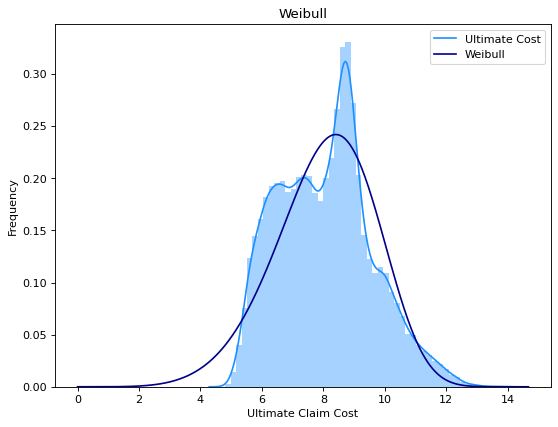

In [165]:
figure(figsize=(8, 6), dpi=80)

sns.distplot(df['UltimateIncurredClaimCost_log'], color="dodgerblue", label="Compact")

y_values, counts = np.unique(df.UltimateIncurredClaimCost_log, return_counts=True)
y_a = np.arange(0,np.max(y_values+1),0.01)
probs=spst.weibull_min.pdf(x=y_a,c=c,scale=1/lmbda)
plt.plot(y_a,probs,c='darkblue')
# Add labels
plt.legend(['Ultimate Cost','Weibull'])
plt.title('Weibull')
plt.xlabel('Ultimate Claim Cost')
plt.ylabel('Frequency')

##Weilbull-Gamma

In [166]:
class WG_C(GenericLikelihoodModel):
    def loglike(self, params):
        y=self.endog
        alpha,c,gamma=np.exp(params)
        likelihood=c*gamma*y**c*(alpha/(alpha+y**c))**gamma/y/(alpha+y**c)
        loglikelihood=np.log(likelihood)
        return np.sum(loglikelihood)

Model=WG_C(df.UltimateIncurredClaimCost_log).fit(start_params=-np.random.rand(3))
print(Model.summary(xname=["log_alpha","log_c",'log_gamma']))

Optimization terminated successfully.
         Current function value: 1.848750
         Iterations: 371
         Function evaluations: 666
                                       WG_C Results                                      
Dep. Variable:     UltimateIncurredClaimCost_log   Log-Likelihood:                -99341.
Model:                                      WG_C   AIC:                               nan
Method:                       Maximum Likelihood   BIC:                               nan
Date:                           Fri, 31 Dec 2021                                         
Time:                                   17:15:58                                         
No. Observations:                          53734                                         
Df Residuals:                                NaN                                         
Df Model:                                    NaN                                         
                 coef    std err          z      P

In [167]:
alpha = np.exp(Model.params[0])
c = np.exp(Model.params[1])
gamma = np.exp(Model.params[2])

Text(0, 0.5, 'Frequency')

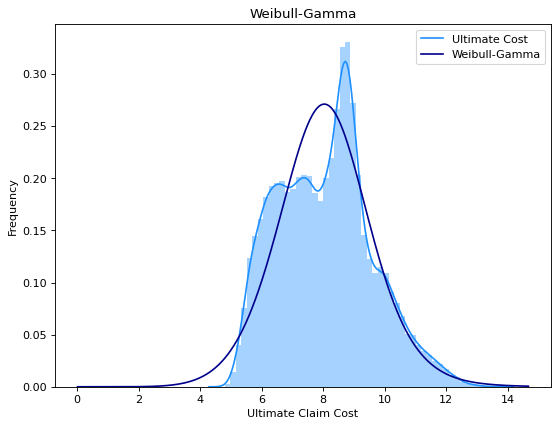

In [168]:
figure(figsize=(8, 6), dpi=80)

sns.distplot(df['UltimateIncurredClaimCost_log'], color="dodgerblue", label="Compact")
y_values, counts = np.unique(df.UltimateIncurredClaimCost_log, return_counts=True)
y_a = np.arange(0,np.max(y_values+1),0.01)

probs=c*gamma*y_a**c*(alpha/(alpha+y_a**c))**gamma/y_a/(alpha+y_a**c)
plt.plot(y_a,probs,c='darkblue')

# Add labels
plt.legend(['Ultimate Cost','Weibull-Gamma'])
plt.title('Weibull-Gamma')
plt.xlabel('Ultimate Claim Cost')
plt.ylabel('Frequency')

##Weibull - 2Segment

In [169]:
# 2-segment
class Weibull_C(GenericLikelihoodModel):
    def loglike(self, params):
        #time
        t=self.endog
        x=self.exog
        #transform it into one-d structure
        c1,lmbda1,c2,lmbda2=np.exp(params[0:4])
        p = np.exp(params[4])/(1+np.exp(params[4]))
        likelihood= p*spst.weibull_min.pdf(x=t,c=c1,scale=1/lmbda1)+(1-p)*spst.weibull_min.pdf(x=t,c=c2,scale=1/lmbda2)
        loglikelihood=np.log(likelihood)
        return np.sum(loglikelihood)

Model=Weibull_C(df.UltimateIncurredClaimCost_log,df[['Age']]).fit(start_params=[3.9,-2.1,1.69,-2.16,-2.68],maxiter = 20000)

print(Model.summary(xname=["log_c1","log_lmbda1","log_c2","log_lmbda2",'p_lDaysWorkedPerWeekog']))

Optimization terminated successfully.
         Current function value: 1.862836
         Iterations: 192
         Function evaluations: 322
                                    Weibull_C Results                                    
Dep. Variable:     UltimateIncurredClaimCost_log   Log-Likelihood:            -1.0010e+05
Model:                                 Weibull_C   AIC:                         2.002e+05
Method:                       Maximum Likelihood   BIC:                         2.002e+05
Date:                           Fri, 31 Dec 2021                                         
Time:                                   17:16:14                                         
No. Observations:                          53734                                         
Df Residuals:                              53733                                         
Df Model:                                      0                                         
                             coef    std err      

In [170]:
params=Model.params[:-1]
c1,lmbda1,c2,lmbda2=np.exp(params)
p = np.exp(Model.params[4])/(1+np.exp(Model.params[4]))

Text(0, 0.5, 'Frequency')

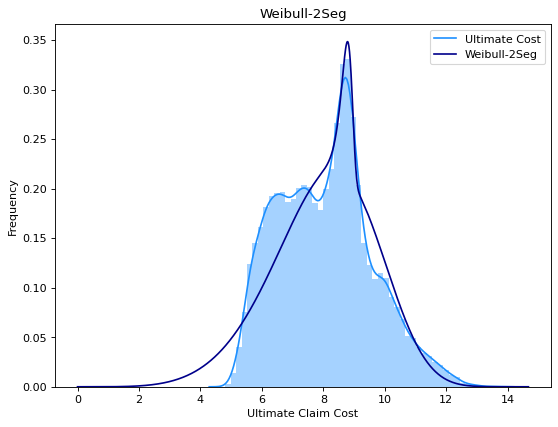

In [171]:
figure(figsize=(8, 6), dpi=80)

sns.distplot(df['UltimateIncurredClaimCost_log'], color="dodgerblue", label="Compact")
y_values, counts = np.unique(df.UltimateIncurredClaimCost_log, return_counts=True)
y_a = np.arange(0,np.max(y_values+1),0.01)

probs=p*spst.weibull_min.pdf(x=y_a,c=c1,scale=1/lmbda1)+(1-p)*spst.weibull_min.pdf(x=y_a,c=c2,scale=1/lmbda2)
plt.plot(y_a,probs,c='darkblue')

# Add labels
plt.legend(['Ultimate Cost','Weibull-2Seg'])
plt.title('Weibull-2Seg')
plt.xlabel('Ultimate Claim Cost')
plt.ylabel('Frequency')

##Weibull - 2Segment - Covariates

###Model

In [174]:
class Weibull_C(GenericLikelihoodModel):
    def loglike(self, params):
        t=self.endog
        x=self.exog
        c1,lmbda1,c2,lmbda2=np.exp(params[0:4])
        cov = params[4]+params[5]*x[:,0]+params[6]*x[:,1]+params[7]*x[:,2]+params[8]*x[:,3]
        p = np.exp(cov)/(1+np.exp(cov))
        likelihood= p*spst.weibull_min.pdf(x=t,c=c1,scale=1/lmbda1)+(1-p)*spst.weibull_min.pdf(x=t,c=c2,scale=1/lmbda2)
        loglikelihood=np.log(likelihood)
        return np.sum(loglikelihood)
 
Model=Weibull_C(df["UltimateIncurredClaimCost_log"],df[['Age','WeeklyWages','Year','InitialIncurredCalimsCost_log']]).fit(start_params=[2.23,-1.96,2.13,-2.26,20,0,0,0,-4],maxiter = 5000)

print(Model.summary(xname=["log_c1","log_lmbda1","log_c2","log_lmbda2",'p_intercept','age','WeeklyWages','year','InitialIncurredCalimsCost_log']))

Optimization terminated successfully.
         Current function value: 1.455771
         Iterations: 1300
         Function evaluations: 1917
                                    Weibull_C Results                                    
Dep. Variable:     UltimateIncurredClaimCost_log   Log-Likelihood:                -78224.
Model:                                 Weibull_C   AIC:                         1.565e+05
Method:                       Maximum Likelihood   BIC:                         1.565e+05
Date:                           Fri, 31 Dec 2021                                         
Time:                                   17:17:46                                         
No. Observations:                          53734                                         
Df Residuals:                              53730                                         
Df Model:                                      3                                         
                                    coef    std 

In [175]:
c1,lmbda1,c2,lmbda2=np.exp(Model.params[0:4])
c1,c2,1/lmbda1,1/lmbda2

(9.308879057996608, 8.461422038096224, 7.105287421053027, 9.671112617356378)

###Segment Analysis

Text(0.5, 0, 'Ultimate Claim Cost')

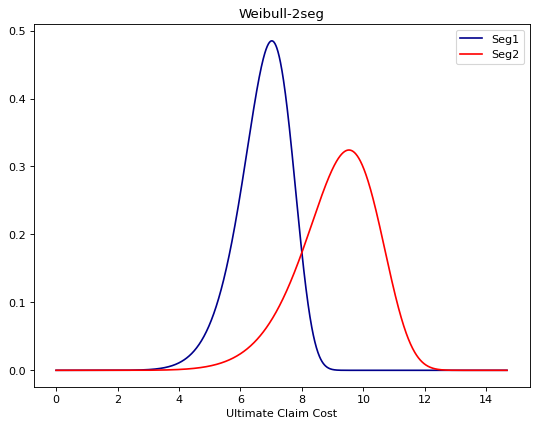

In [177]:
figure(figsize=(8, 6), dpi=80)

y_values, counts = np.unique(df.UltimateIncurredClaimCost_log, return_counts=True)
y_a = np.arange(0,np.max(y_values+1),0.01)

probs1=spst.weibull_min.pdf(x=y_a,c=c1,scale=1/lmbda1)
plt.plot(y_a,probs1,c='darkblue')

probs1=spst.weibull_min.pdf(x=y_a,c=c2,scale=1/lmbda2)
plt.plot(y_a,probs1,c='red')

# Add labels
plt.legend(['Seg1','Seg2'])
plt.title('Weibull-2seg')
plt.xlabel('Ultimate Claim Cost')

In [215]:
from mpmath import gamma
expectation_1 = float(gamma(1+1/c1))/lmbda1
expectation_1

6.738653020587898

In [216]:
from mpmath import gamma
expectation_2 = float(gamma(1+1/c2))/lmbda2
expectation_2

9.132145872545015

###Cost Estimation Analysis

In [217]:
#Genrate Claims' Info age, WeeklyWages, year, InitialIncurredCalimsCost_log
Claimer1 = [48,300,2,8]
Claimer2 = [56,500,10,7.6]
Claimer3 = [23,200,2,7]
Claimer4 = [25,500,5,7.2]

In [218]:
#p calculation
cov1 = np.array(Model.params[5:9]) @ np.array(Claimer1) + Model.params[4]
p1 = np.exp(cov1)/(1+np.exp(cov1))
cov2 = np.array(Model.params[5:9]) @ np.array(Claimer2) + Model.params[4]
p2 = np.exp(cov2)/(1+np.exp(cov2))
cov3 = np.array(Model.params[5:9]) @ np.array(Claimer3) + Model.params[4]
p3 = np.exp(cov3)/(1+np.exp(cov3))
cov4 = np.array(Model.params[5:9]) @ np.array(Claimer4) + Model.params[4]
p4 = np.exp(cov4)/(1+np.exp(cov4))
p1,p2,p3,p4

(0.19736902346046856,
 0.33451386519459003,
 0.9795896134097454,
 0.8911442787930626)

In [182]:
#expectation calculation
exp_claimer1 = p1*expectation_1+(1-p1)*expectation_2
exp_claimer2 = p2*expectation_1+(1-p2)*expectation_2
exp_claimer3 = p3*expectation_1+(1-p3)*expectation_2
exp_claimer4 = p4*expectation_1+(1-p4)*expectation_2
exp_claimer1,exp_claimer2,exp_claimer3,exp_claimer4

(7589.270030146058, 6436.7839347079425, 1015.939658525887, 1759.1832035489729)

###Premium Adjustment Analysis

In [79]:
#p1
p11=spst.weibull_min.pdf(x=np.log(2000),c=c1,scale=1/lmbda1)
p21=spst.weibull_min.pdf(x=np.log(3000),c=c1,scale=1/lmbda1)
p31=spst.weibull_min.pdf(x=np.log(4000),c=c1,scale=1/lmbda1)
p11,p21,p31

(0.3524397561228997, 0.16922771632196207, 0.06957871755371238)

In [80]:
#p2
p12=spst.weibull_min.pdf(x=np.log(2000),c=c2,scale=1/lmbda2)
p22=spst.weibull_min.pdf(x=np.log(3000),c=c2,scale=1/lmbda2)
p32=spst.weibull_min.pdf(x=np.log(4000),c=c2,scale=1/lmbda2)
p12,p22,p32

(0.12730704472701174, 0.1745864877988031, 0.21175317927055867)

In [81]:
p_seg1_2000 = p11*p1/(p11*p1+p12*(1-p1))
p_seg1_3000 = p21*p1/(p21*p1+p22*(1-p1))
p_seg1_4000 = p31*p1/(p31*p1+p32*(1-p1))
p_seg1_2000,p_seg1_3000,p_seg1_4000

(5.966597915343133e-39, 2.0890805333450164e-39, 7.081753352675399e-40)

In [82]:
exp_2000 = p_seg1_2000*expectation_1+(1-p_seg1_2000)*expectation_2
exp_3000 = p_seg1_3000*expectation_1+(1-p_seg1_3000)*expectation_2
exp_4000 = p_seg1_4000*expectation_1+(1-p_seg1_4000)*expectation_2
exp_2000,exp_3000,exp_4000

(9247.632950134632, 9247.632950134632, 9247.632950134632)

##Topic Exploration

###Back

In [ ]:
cost_back = df[df['main_topic']=='back'].UltimateIncurredClaimCost_log.values

In [ ]:
dist = distfit(distr='full')

In [ ]:
dist.fit_transform(cost_back)

[distfit] >fit..
[distfit] >transform..
[distfit] >[alpha          ] [0.48 sec] [RSS: 0.2830449] [loc=-13.300 scale=414.618]
[distfit] >[anglit         ] [0.15 sec] [RSS: 0.7072857] [loc=9.360 scale=5.339]
[distfit] >[arcsine        ] [0.18 sec] [RSS: 1.6963356] [loc=5.164 scale=8.388]
[distfit] >[beta           ] [0.78 sec] [RSS: 0.2852913] [loc=-1.263 scale=2904.157]
[distfit] >[betaprime      ] [0.68 sec] [RSS: 0.2842326] [loc=-2.850 scale=73.405]
[distfit] >[bradford       ] [0.20 sec] [RSS: 1.1327246] [loc=5.169 scale=8.384]
[distfit] >[burr           ] [2.98 sec] [RSS: 0.2066683] [loc=0.029 scale=8.960]
[distfit] >[cauchy         ] [0.03 sec] [RSS: 0.0537555] [loc=8.789 scale=0.535]
[distfit] >[chi            ] [0.33 sec] [RSS: 0.2891285] [loc=1.616 scale=1.691]
[distfit] >[chi2           ] [0.48 sec] [RSS: 0.2877516] [loc=1.039 scale=0.091]
[distfit] >[cosine         ] [0.15 sec] [RSS: 0.5478182] [loc=9.220 scale=1.379]
[distfit] >[dgamma         ] [0.21 sec] [RSS: 0.0482077] [l

{'alpha': 0.05,
 'bins': 50,
 'bound': 'both',
 'distr': 'full',
 'f': 1.5,
 'histdata': (array([1.71586775e-03, 1.37269420e-03, 1.71586775e-03, 1.26974214e-02,
         1.47564627e-02, 3.46605286e-02, 3.08856196e-02, 5.83395036e-02,
         5.42214210e-02, 7.06937515e-02, 8.20184786e-02, 9.40295529e-02,
         1.14276792e-01, 1.16335834e-01, 1.32121817e-01, 1.33494511e-01,
         1.49280495e-01, 1.99727007e-01, 2.70420758e-01, 4.00826707e-01,
         5.75158871e-01, 6.38645978e-01, 5.49420855e-01, 3.74402344e-01,
         2.48114477e-01, 1.93206709e-01, 1.45848759e-01, 1.46535106e-01,
         1.67125519e-01, 1.65066478e-01, 1.25944693e-01, 1.05354280e-01,
         9.02546438e-02, 6.82915366e-02, 6.41734540e-02, 5.83395036e-02,
         5.18192062e-02, 5.04465120e-02, 4.39262145e-02, 3.22583138e-02,
         2.98560989e-02, 2.02472395e-02, 2.26494543e-02, 1.02952065e-02,
         5.14760326e-03, 4.11808261e-03, 2.05904130e-03, 3.43173551e-04,
         6.86347102e-04, 6.86347102e

In [ ]:
dist.summary.sort_values(by='score')

,distr,score,LLE,loc,scale,arg
0,dgamma,0.0482077,NaN,8.8056,0.934481,"(0.9223397640787399,)"
1,dweibull,0.0510793,NaN,8.80561,0.853865,"(0.9638337550577296,)"
2,foldcauchy,0.0519028,NaN,5.16856,0.542066,"(6.677694204885608,)"
3,cauchy,0.0537555,NaN,8.78878,0.534562,()
4,gennorm,0.0590899,NaN,8.8027,0.824426,"(0.9686871081517536,)"
...,...,...,...,...,...,...
75,truncnorm,1.82228,NaN,0.00218909,7.1343e-31,"(0.9015482215897133, 1.6009849280375819)"
76,weibull_max,3.7267,NaN,13.5522,1.26325,"(0.5749575968857259,)"
77,exponpow,3.93171,NaN,5.16856,1.45267,"(0.2924988299274732,)"
78,vonmises,1.68407e+54,NaN,8.14953,1.17964e-27,"(1.7243054499658772,)"


[distfit] >plot..


(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd3f2208610>)

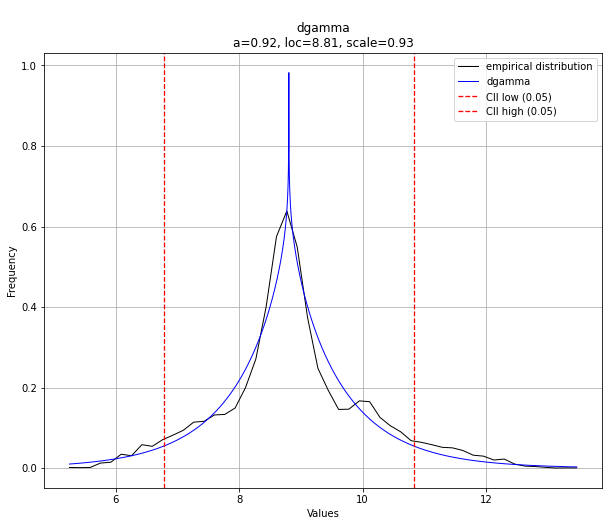

In [ ]:
dist.plot()

###Eye

In [ ]:
cost_eye = df[df['main_topic']=='eye'].UltimateIncurredClaimCost_log.values

In [ ]:
dist.fit_transform(cost_eye)

[distfit] >Cleaning previous fitted model results..
[distfit] >fit..
[distfit] >transform..
[distfit] >[alpha          ] [0.16 sec] [RSS: 0.0261038] [loc=3.314 scale=10.341]
[distfit] >[anglit         ] [0.03 sec] [RSS: 1.5093772] [loc=7.407 scale=5.638]
[distfit] >[arcsine        ] [0.09 sec] [RSS: 2.1607651] [loc=4.800 scale=7.033]
[distfit] >[beta           ] [0.24 sec] [RSS: 0.0566185] [loc=4.791 scale=2317274307589.991]
[distfit] >[betaprime      ] [0.24 sec] [RSS: 0.2854478] [loc=-1.269 scale=2.065]
[distfit] >[bradford       ] [0.13 sec] [RSS: 1.1880722] [loc=4.795 scale=7.038]
[distfit] >[burr           ] [0.85 sec] [RSS: 0.0201211] [loc=2.616 scale=0.940]
[distfit] >[cauchy         ] [0.01 sec] [RSS: 0.2838882] [loc=5.998 scale=0.459]
[distfit] >[chi            ] [0.10 sec] [RSS: 0.6107681] [loc=4.803 scale=1.825]
[distfit] >[chi2           ] [0.11 sec] [RSS: 3.3093027] [loc=4.803 scale=1.105]
[distfit] >[cosine         ] [0.03 sec] [RSS: 1.2546871] [loc=6.973 scale=1.549]
[di

{'alpha': 0.05,
 'bins': 50,
 'bound': 'both',
 'distr': 'full',
 'f': 1.5,
 'histdata': (array([0.01936379, 0.06583689, 0.22655636, 0.39889411, 0.49764945,
         0.63900513, 0.58865927, 0.53637703, 0.53831341, 0.47828565,
         0.4744129 , 0.36016653, 0.30982067, 0.24592015, 0.24979291,
         0.17427413, 0.21687447, 0.17233775, 0.13167378, 0.10456448,
         0.0929462 , 0.05034586, 0.05034586, 0.06970965, 0.05228224,
         0.04840948, 0.04066396, 0.01936379, 0.03291845, 0.03291845,
         0.02517293, 0.01936379, 0.02517293, 0.01161828, 0.02130017,
         0.01742741, 0.01355465, 0.0096819 , 0.00580914, 0.01355465,
         0.00774552, 0.00387276, 0.00193638, 0.00193638, 0.00193638,
         0.00193638, 0.        , 0.00193638, 0.00387276, 0.00580914]),
  array([ 4.87339333,  5.01399442,  5.1545955 ,  5.29519658,  5.43579767,
          5.57639875,  5.71699984,  5.85760092,  5.99820201,  6.13880309,
          6.27940417,  6.42000526,  6.56060634,  6.70120743,  6.84180851

In [ ]:
dist.summary.sort_values(by='score')

,distr,score,LLE,loc,scale,arg
0,johnsonsu,0.0148956,NaN,4.83465,0.335723,"(-3.327511077074141, 1.6461144371728589)"
1,powerlognorm,0.0154831,NaN,4.36021,1.06571,"(0.20170566889452024, 0.26083896609991897)"
2,exponweib,0.0158814,NaN,4.55173,0.175509,"(27.44569348534226, 0.6028416062423094)"
3,f,0.0169651,NaN,4.28537,1.69554,"(684.2267053730133, 11.587660848310774)"
4,invgamma,0.0169658,NaN,4.27116,9.89074,"(5.793339313344081,)"
...,...,...,...,...,...,...
75,chi2,3.3093,NaN,4.80309,1.10547,"(0.9789798726166332,)"
76,exponpow,4.15893,NaN,4.80309,1.25315,"(0.52021391380994,)"
77,vonmises,1.46949e+56,NaN,5.79673,1.31287e-28,"(1.739846546757921,)"
78,powernorm,NaN,NaN,4.73628,0.00579523,"(1.8961457517754175e-05,)"


[distfit] >plot..


(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd3f066dcd0>)

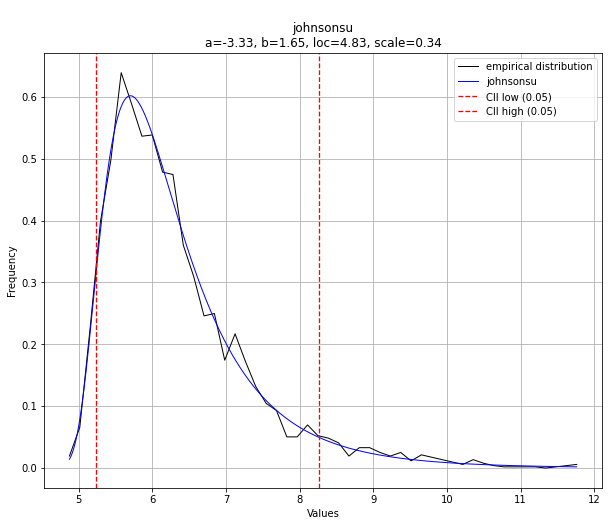

In [ ]:
dist.plot()

###Strained

In [ ]:
cost_strained = df[df['main_topic']=='strained'].UltimateIncurredClaimCost_log.values

In [ ]:
dist.fit_transform(cost_strained)

[distfit] >Cleaning previous fitted model results..
[distfit] >fit..
[distfit] >transform..
[distfit] >[alpha          ] [0.27 sec] [RSS: 0.0202722] [loc=-7.892 scale=186.047]
[distfit] >[anglit         ] [0.06 sec] [RSS: 0.2165436] [loc=8.928 scale=5.432]
[distfit] >[arcsine        ] [0.18 sec] [RSS: 1.0541647] [loc=4.996 scale=8.197]
[distfit] >[beta           ] [0.12 sec] [RSS: 0.0198144] [loc=4.808 scale=10.396]
[distfit] >[betaprime      ] [0.46 sec] [RSS: 0.0200640] [loc=-0.260 scale=9.927]
[distfit] >[bradford       ] [0.11 sec] [RSS: 0.4519476] [loc=4.996 scale=8.197]
[distfit] >[burr           ] [1.11 sec] [RSS: 0.0296320] [loc=0.069 scale=7.821]
[distfit] >[cauchy         ] [0.02 sec] [RSS: 0.1173653] [loc=8.126 scale=0.875]
[distfit] >[chi            ] [0.11 sec] [RSS: 0.0184240] [loc=4.824 scale=2.107]
[distfit] >[chi2           ] [0.18 sec] [RSS: 0.0192251] [loc=3.261 scale=0.204]
[distfit] >[cosine         ] [0.04 sec] [RSS: 0.1097217] [loc=8.588 scale=1.467]
[distfit] >[

{'alpha': 0.05,
 'bins': 50,
 'bound': 'both',
 'distr': 'full',
 'f': 1.5,
 'histdata': (array([0.00533124, 0.00990088, 0.01447052, 0.05102762, 0.0487428 ,
         0.07463741, 0.09596239, 0.12414182, 0.14851322, 0.16146053,
         0.18507032, 0.19344799, 0.24066758, 0.24752203, 0.29702644,
         0.28941038, 0.23457473, 0.23685954, 0.24676043, 0.27570146,
         0.27874789, 0.30768893, 0.29321841, 0.25437649, 0.22086581,
         0.17745426, 0.14089716, 0.12947306, 0.12490343, 0.12414182,
         0.11957218, 0.10662488, 0.09367757, 0.09367757, 0.08377669,
         0.06549814, 0.06016689, 0.05255083, 0.04798119, 0.03884192,
         0.02589461, 0.02741783, 0.01599373, 0.01447052, 0.00990088,
         0.00380803, 0.00228482, 0.00304643, 0.00076161, 0.00076161]),
  array([ 5.07816556,  5.24210792,  5.40605029,  5.56999266,  5.73393503,
          5.8978774 ,  6.06181977,  6.22576214,  6.38970451,  6.55364688,
          6.71758924,  6.88153161,  7.04547398,  7.20941635,  7.37335872

In [ ]:
dist.summary.sort_values(by='score')

,distr,score,LLE,loc,scale,arg
0,nakagami,0.018424,NaN,4.82436,3.73622,"(1.572260766030242,)"
1,chi,0.018424,NaN,4.82436,2.10693,"(3.144551306332901,)"
2,maxwell,0.0184391,NaN,4.88784,2.12324,()
3,powernorm,0.0186254,NaN,5.93691,0.414008,"(0.04100973601431851,)"
4,gengamma,0.0186494,NaN,4.7841,3.10167,"(1.5171589750242584, 2.0733801929427904)"
...,...,...,...,...,...,...
75,arcsine,1.05416,NaN,4.99619,8.1972,()
76,reciprocal,1.2322,NaN,0.00218909,7.1343e-31,"(0.9015482215897133, 1.6009849280375819)"
77,truncnorm,1.2322,NaN,0.00218909,7.1343e-31,"(0.9015482215897133, 1.6009849280375819)"
78,vonmises,2.37526e+60,NaN,7.716,9.05755e-31,"(1.0707587480586769,)"


[distfit] >plot..


(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd3f4e07a50>)

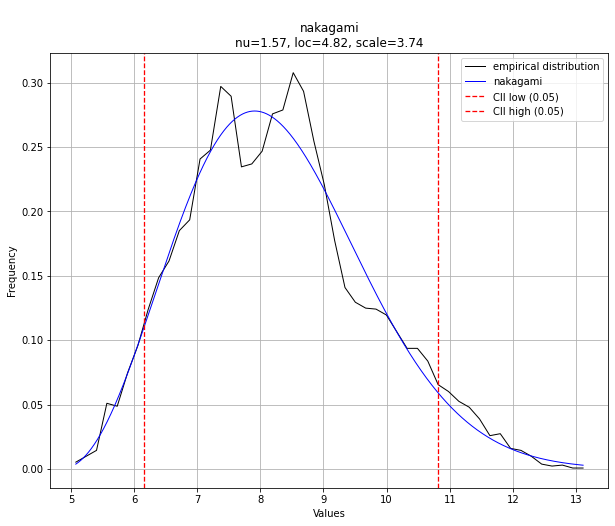

In [ ]:
dist.plot()

###Limb

In [ ]:
cost_limb = df[df['main_topic']=='limb'].UltimateIncurredClaimCost_log.values

In [ ]:
dist.fit_transform(cost_limb)

[distfit] >Cleaning previous fitted model results..
[distfit] >fit..
[distfit] >transform..
[distfit] >[alpha          ] [0.35 sec] [RSS: 0.0163182] [loc=-7.207 scale=173.005]
[distfit] >[anglit         ] [0.09 sec] [RSS: 0.2554136] [loc=9.087 scale=5.838]
[distfit] >[arcsine        ] [0.23 sec] [RSS: 0.9942759] [loc=4.951 scale=8.730]
[distfit] >[beta           ] [0.15 sec] [RSS: 0.0112432] [loc=4.891 scale=11.063]
[distfit] >[betaprime      ] [0.56 sec] [RSS: 0.0149660] [loc=-0.286 scale=11.735]
[distfit] >[bradford       ] [0.13 sec] [RSS: 0.4563413] [loc=4.951 scale=8.721]
[distfit] >[burr           ] [1.68 sec] [RSS: 0.0296494] [loc=-0.564 scale=8.381]
[distfit] >[cauchy         ] [0.03 sec] [RSS: 0.1134048] [loc=8.153 scale=0.874]
[distfit] >[chi            ] [0.27 sec] [RSS: 0.0111108] [loc=4.918 scale=2.077]
[distfit] >[chi2           ] [0.21 sec] [RSS: 0.0154879] [loc=3.623 scale=0.215]
[distfit] >[cosine         ] [0.06 sec] [RSS: 0.1362378] [loc=8.698 scale=1.584]
[distfit] 

{'alpha': 0.05,
 'bins': 50,
 'bound': 'both',
 'distr': 'full',
 'f': 1.5,
 'histdata': (array([0.0010244 , 0.0030732 , 0.00819521, 0.03534183, 0.05173224,
         0.07119586, 0.11524509, 0.13419651, 0.15724552, 0.18541655,
         0.21614857, 0.22588038, 0.22024617, 0.24073419, 0.255588  ,
         0.26071001, 0.2576368 , 0.2591734 , 0.26378321, 0.26327101,
         0.29297863, 0.29656403, 0.27044181, 0.21768517, 0.19412395,
         0.14444051, 0.13573311, 0.13829411, 0.1280501 , 0.10448888,
         0.09885468, 0.09424487, 0.07222026, 0.06402505, 0.05787865,
         0.04200043, 0.03073202, 0.02561002, 0.02151242, 0.02765882,
         0.01485381, 0.01075621, 0.00717081, 0.005122  , 0.0030732 ,
         0.0030732 , 0.0040976 , 0.0005122 , 0.0005122 , 0.0010244 ]),
  array([ 5.03801274,  5.21242411,  5.38683547,  5.56124684,  5.7356582 ,
          5.91006957,  6.08448093,  6.2588923 ,  6.43330366,  6.60771503,
          6.78212639,  6.95653776,  7.13094912,  7.30536049,  7.47977185

In [ ]:
dist.summary.sort_values(by='score')

,distr,score,LLE,loc,scale,arg
0,exponweib,0.0108386,NaN,4.92706,3.3874,"(1.339970632048976, 2.1888536792635955)"
1,gengamma,0.0108591,NaN,4.92438,3.06324,"(1.4398566521186664, 2.0732171161255506)"
2,maxwell,0.0109661,NaN,4.93337,2.09259,()
3,weibull_min,0.0110929,NaN,4.94334,3.75789,"(2.5535108298775766,)"
4,chi,0.0111108,NaN,4.91835,2.07737,"(3.067554938083283,)"
...,...,...,...,...,...,...
75,reciprocal,1.16349,NaN,0.00218909,7.1343e-31,"(0.9015482215897133, 1.6009849280375819)"
76,foldnorm,1.30255,NaN,4.95081,1.96665,"(2.3878501016454126e-08,)"
77,exponpow,3.24054,NaN,4.95081,1.36863,"(0.31964068625641734,)"
78,vonmises,5.45324e+55,NaN,6.90034,1.91492e-28,"(1.3107324678503307,)"


[distfit] >plot..


(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd3f0605a10>)

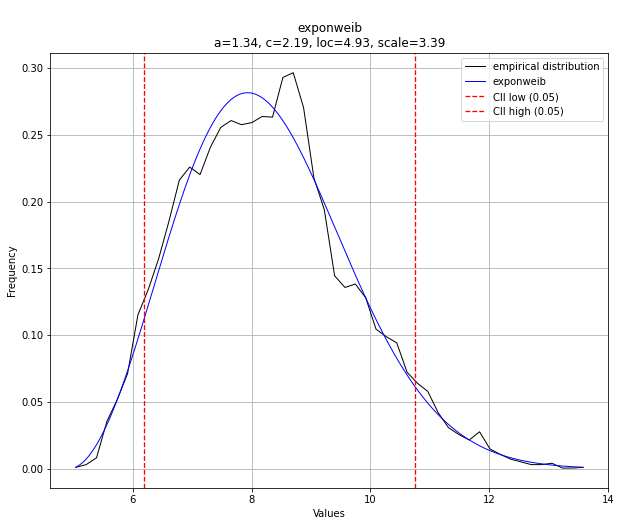

In [ ]:
dist.plot()

###Finger

In [ ]:
cost_finger = df[df['main_topic']=='finger'].UltimateIncurredClaimCost_log.values

In [ ]:
dist.fit_transform(cost_finger)

[distfit] >Cleaning previous fitted model results..
[distfit] >fit..
[distfit] >transform..
[distfit] >[alpha          ] [0.31 sec] [RSS: 0.0224507] [loc=2.120 scale=20.201]
[distfit] >[anglit         ] [0.09 sec] [RSS: 0.6272436] [loc=8.324 scale=6.612]
[distfit] >[arcsine        ] [0.22 sec] [RSS: 1.1521200] [loc=4.946 scale=8.571]
[distfit] >[beta           ] [0.69 sec] [RSS: 0.0167381] [loc=4.939 scale=81733.962]
[distfit] >[betaprime      ] [0.71 sec] [RSS: 0.0886706] [loc=-0.391 scale=0.852]
[distfit] >[bradford       ] [0.40 sec] [RSS: 0.5381943] [loc=4.946 scale=8.746]
[distfit] >[burr           ] [2.41 sec] [RSS: 0.0188765] [loc=-1.293 scale=4.140]
[distfit] >[cauchy         ] [0.03 sec] [RSS: 0.1638528] [loc=6.717 scale=0.715]
[distfit] >[chi            ] [0.40 sec] [RSS: 0.0672718] [loc=4.945 scale=1.981]
[distfit] >[chi2           ] [0.34 sec] [RSS: 0.0167281] [loc=4.938 scale=0.394]
[distfit] >[cosine         ] [0.07 sec] [RSS: 0.4800714] [loc=7.830 scale=1.811]
[distfit] 

{'alpha': 0.05,
 'bins': 50,
 'bound': 'both',
 'distr': 'full',
 'f': 1.5,
 'histdata': (array([0.01168486, 0.05149996, 0.114252  , 0.21984855, 0.30034429,
         0.34665097, 0.36872238, 0.41243243, 0.38257111, 0.3843022 ,
         0.32934006, 0.27394515, 0.27481069, 0.26182751, 0.23239896,
         0.21032755, 0.18349564, 0.16748305, 0.14541164, 0.14714273,
         0.12810073, 0.10819319, 0.09564278, 0.0809285 , 0.06621423,
         0.06448314, 0.07270582, 0.06145373, 0.05799155, 0.05193273,
         0.04111341, 0.03505459, 0.0333235 , 0.01947477, 0.02120586,
         0.01211764, 0.01644536, 0.01125209, 0.01125209, 0.00735714,
         0.00562605, 0.00519327, 0.00173109, 0.00216386, 0.00086555,
         0.00216386, 0.        , 0.        , 0.00043277, 0.00043277]),
  array([ 5.03140987,  5.20283814,  5.3742664 ,  5.54569466,  5.71712293,
          5.88855119,  6.05997945,  6.23140771,  6.40283598,  6.57426424,
          6.7456925 ,  6.91712076,  7.08854903,  7.25997729,  7.43140555

In [ ]:
dist.summary.sort_values(by='score')

,distr,score,LLE,loc,scale,arg
0,fatiguelife,0.00736359,NaN,4.5275,2.32478,"(0.5145543967249191,)"
1,recipinvgauss,0.00745466,NaN,4.59267,0.59842,"(0.30391027262249715,)"
2,invgauss,0.0078335,NaN,4.46719,10.173,"(0.2647202189770844,)"
3,johnsonsb,0.00911228,NaN,4.86796,11.385,"(2.0217178864230796, 1.3146109831212809)"
4,powerlognorm,0.00987344,NaN,4.7411,3.41308,"(2.400995004927755, 0.7109510868689491)"
...,...,...,...,...,...,...
75,weibull_min,2.25941,NaN,4.9457,1.06246,"(0.7730507453936899,)"
76,vonmises,4.56804e+54,NaN,5.85201,7.85237e-28,"(1.6806151995619436,)"
77,mielke,NaN,NaN,-1.54022,4.76544,"(820.4161386412316, 8.674992255214875)"
78,powernorm,NaN,NaN,4.9034,0.0120296,"(4.2081872297036055e-05,)"


[distfit] >plot..


(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd3f23264d0>)

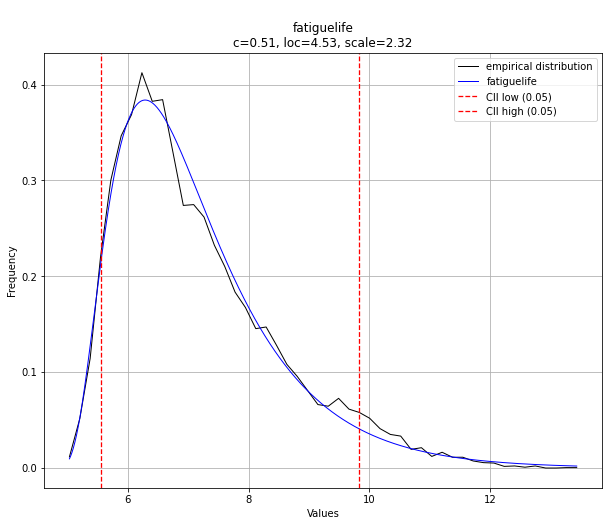

In [ ]:
dist.plot()